In [1]:
import torch
from torch import nn
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import numpy as np
import matplotlib.pyplot as plt

In [2]:
NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42
X, y = make_blobs(n_samples=3000, n_features=NUM_FEATURES, centers=NUM_CLASSES, cluster_std=1.5,  random_state=RANDOM_SEED)
X.shape, y.shape

((3000, 2), (3000,))

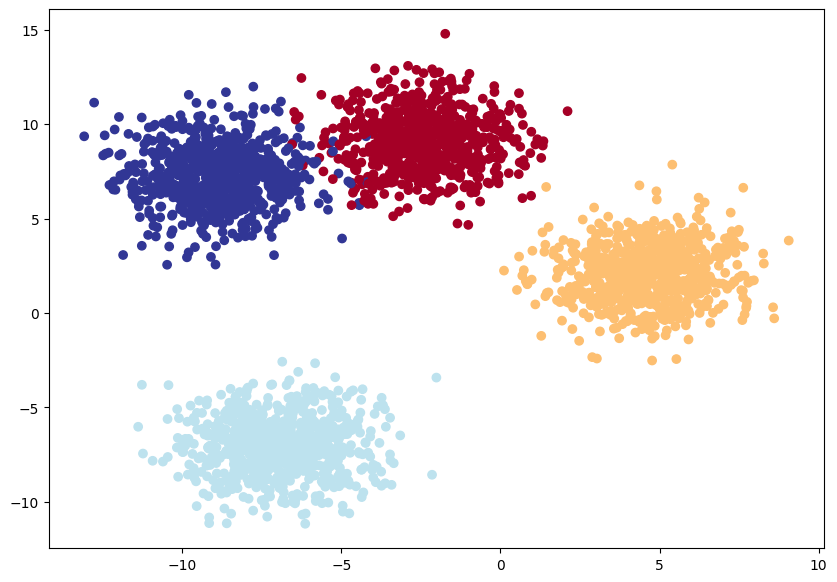

In [3]:
plt.figure(figsize = (10,7))
plt.scatter(X[:,0], X[:,1], c=y, cmap='RdYlBu')

In [4]:
X,y = torch.from_numpy(X).type(torch.float), torch.from_numpy(y).type(torch.float)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)


In [5]:
class MultiClassClassifier(nn.Module):
  def __init__(self, input_features, output_features, hidden_units =10):
    super().__init__()
    # Assign the nn.Sequential object to self.self_linear_layer_stack
    self.linear_layer_stack = nn.Sequential(
        nn.Linear(in_features = input_features, out_features = hidden_units),
        nn.ReLU(),
        nn.Linear(in_features = hidden_units, out_features = hidden_units),
        nn.ReLU(),
        nn.Linear(in_features = hidden_units, out_features = output_features)
    )

  def forward(self, x):
    return self.linear_layer_stack(x)

In [6]:
if torch.cuda.is_available():
  device = 'cuda'
else:
  device = 'cpu'
print(f'Using {device} device')

Using cpu device


In [7]:
def accuracy_fn(y_true, y_pred):
    if y_pred.dim() == 1:  # Binary classification
        # Convert probabilities/logits to 0 or 1
        y_pred = (y_pred > 0.5).long()
    else:  # Multi-class classification
        y_pred = y_pred.argmax(dim=1)

    correct = (y_true == y_pred).sum().item()
    acc = (correct / len(y_true)) * 100
    return acc

In [8]:
model_1 = MultiClassClassifier(input_features=NUM_FEATURES, output_features=NUM_CLASSES)
model_1.to(device)

MultiClassClassifier(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=10, bias=True)
    (1): ReLU()
    (2): Linear(in_features=10, out_features=10, bias=True)
    (3): ReLU()
    (4): Linear(in_features=10, out_features=4, bias=True)
  )
)

In [9]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params = model_1.parameters(), lr = 0.1)

In [10]:
model_1.eval()
with torch.inference_mode():
  y_logits = model_1(X_test.to(device))

y_logits[:10]

tensor([[ 0.5099, -0.3664, -0.3088,  1.3397],
        [ 0.1784,  0.0105,  0.0554,  0.3082],
        [ 0.2017,  0.0420,  0.0434,  0.3376],
        [ 0.5559,  0.2166, -0.1160,  0.5551],
        [ 0.1022, -0.2001,  0.0900,  0.3394],
        [ 0.5941,  0.2441, -0.1337,  0.5822],
        [ 1.0929,  0.5978, -0.3519,  0.7072],
        [ 0.2748,  0.0952,  0.0055,  0.4657],
        [ 0.1399, -0.0102,  0.0748,  0.2398],
        [ 0.2448,  0.0533,  0.0210,  0.4288]])

In [11]:
y_pred_probs = torch.softmax(y_logits, dim=1)
y_pred_probs[:10]

tensor([[0.2410, 0.1003, 0.1063, 0.5525],
        [0.2585, 0.2185, 0.2286, 0.2944],
        [0.2596, 0.2213, 0.2216, 0.2974],
        [0.3103, 0.2210, 0.1585, 0.3101],
        [0.2503, 0.1850, 0.2473, 0.3173],
        [0.3149, 0.2219, 0.1521, 0.3112],
        [0.3960, 0.2414, 0.0934, 0.2693],
        [0.2625, 0.2193, 0.2005, 0.3177],
        [0.2562, 0.2205, 0.2401, 0.2832],
        [0.2613, 0.2158, 0.2089, 0.3141]])

In [12]:
from tqdm import tqdm
epochs = 3000
model_1.to(device)
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)
trainLossList = []
testLossList = []
for epoch in range(epochs):
    #training
    model_1.train()

    #forward pass
    y_logits = model_1(X_train).squeeze()
    y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)

    #compute loss
    loss = loss_fn(y_logits, y_train.type(torch.long))

    #zero grad optimizer
    optimizer.zero_grad()

    #back propagate
    loss.backward()

    #step the optimizer
    optimizer.step()

    acc = accuracy_fn(y_true=y_train, y_pred=y_pred)
    #testing
    model_1.eval()
    with torch.inference_mode():
        test_logits = model_1(X_test).squeeze()
        test_pred = torch.softmax(test_logits, dim=1).argmax(dim=1)
        test_loss  = loss_fn(test_logits, test_pred)
        test_acc = accuracy_fn(y_true=y_test, y_pred=test_pred)

    if(epoch%100==0):
        print(f"epoch:{epoch}|train loss:{loss:.5f}|test loss:{test_loss:.5f}")

    trainLossList.append(loss.cpu().detach().numpy())
    testLossList.append(test_loss.cpu().detach().numpy())

epoch:0|train loss:1.54610|test loss:1.09071
epoch:100|train loss:0.03057|test loss:0.02092
epoch:200|train loss:0.02282|test loss:0.01232
epoch:300|train loss:0.02090|test loss:0.01015
epoch:400|train loss:0.02002|test loss:0.00916
epoch:500|train loss:0.01947|test loss:0.00859
epoch:600|train loss:0.01908|test loss:0.00824
epoch:700|train loss:0.01878|test loss:0.00801
epoch:800|train loss:0.01852|test loss:0.00786
epoch:900|train loss:0.01829|test loss:0.00777
epoch:1000|train loss:0.01809|test loss:0.00770
epoch:1100|train loss:0.01791|test loss:0.00766
epoch:1200|train loss:0.01774|test loss:0.00764
epoch:1300|train loss:0.01758|test loss:0.00763
epoch:1400|train loss:0.01743|test loss:0.00764
epoch:1500|train loss:0.01729|test loss:0.00765
epoch:1600|train loss:0.01716|test loss:0.00767
epoch:1700|train loss:0.01704|test loss:0.00770
epoch:1800|train loss:0.01692|test loss:0.00773
epoch:1900|train loss:0.01680|test loss:0.00777
epoch:2000|train loss:0.01669|test loss:0.00782
epoc

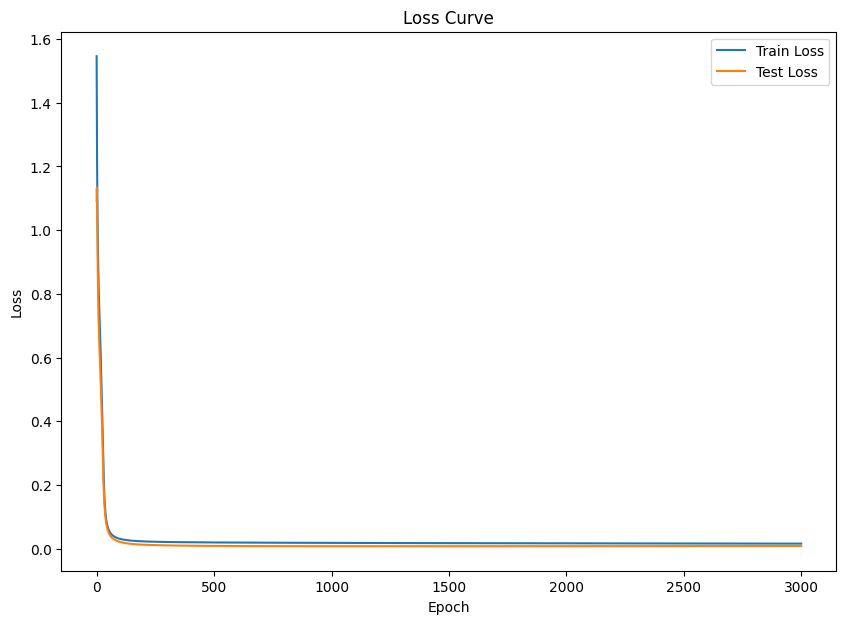

In [13]:
plt.figure(figsize=(10, 7))
plt.plot(trainLossList, label="Train Loss")
plt.plot(testLossList, label="Test Loss")
plt.title("Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

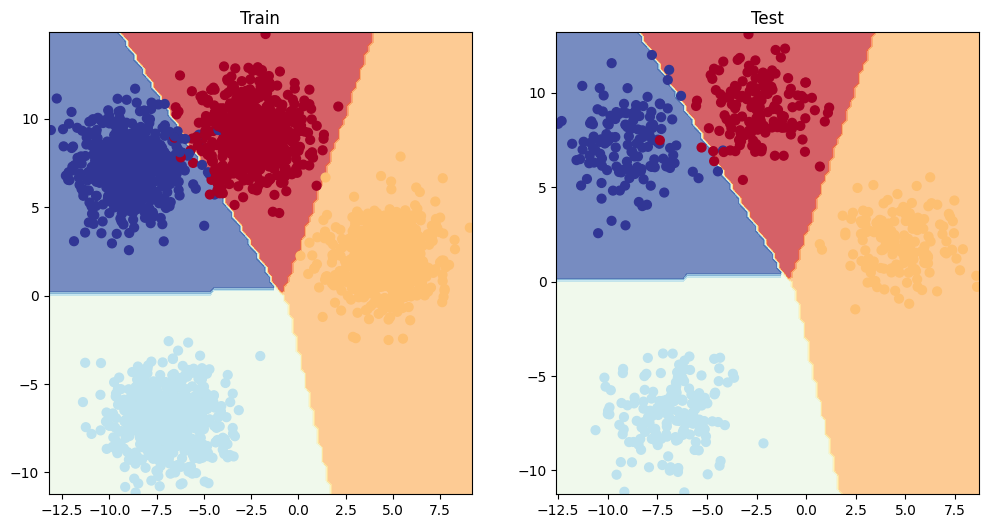

In [14]:

from helper_functions import plot_decision_boundary

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train)

plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_1, X_test, y_test)

plt.show()